installing dependencies

In [1]:
!pip install transformers

DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install torch 

DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!pip install datasets 

DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


importing required libraries

In [4]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


loading dataset , mapping labels , loading tokenizer and model 

In [6]:
dataset=load_dataset("tner/bc5cdr")

# Define the label mapping
label_mapping = {
    'O': 0,
    'B-CHEMICAL': 1,
    'I-CHEMICAL': 2,
    'B-DISEASE': 3,
    'I-DISEASE': 4
}

id_to_label = {v: k for k, v in label_mapping.items()}



# Specify the BlueBERT model name
model_name = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_mapping))

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

preprocess the data (tokenization and label assignment )

In [7]:

# Preprocess the dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding=True)
    labels = []
    for i, label in enumerate(examples['tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] != -100 else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized dataset

In [8]:
tokenized_dataset=dataset.map(tokenize_and_align_labels,batched=True)

Map: 100%|██████████| 5865/5865 [00:02<00:00, 2457.27 examples/s]


importing required libraries for training

In [9]:
import torch
from torch import nn
import numpy as np
from transformers import TrainingArguments, Trainer


initializing training argument for epoch 0.1

In [10]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=0.1,
    weight_decay=0.01,
)


compute metriz function for evaluation during training

In [14]:
import itertools
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                        for prediction, label in zip(predictions, labels)]
    
    true_entities = list(itertools.chain(*true_labels))
    predicted_entities = list(itertools.chain(*true_predictions))
    
    accuracy = accuracy_score(true_entities, predicted_entities)
    precision = precision_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    recall = recall_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

initializing trainer class

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(tokenizer),
)

training of model on epoch 0.1

In [16]:
# # # Train the model
# trainer.train()

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/33 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                               
100%|██████████| 33/33 [1:14:11<00:00, 134.90s/it]

{'eval_loss': 0.6983147263526917, 'eval_accuracy': 0.762776025236593, 'eval_precision': 0.7059973710623302, 'eval_recall': 0.762776025236593, 'eval_f1': 0.6602846055963095, 'eval_runtime': 3526.731, 'eval_samples_per_second': 1.511, 'eval_steps_per_second': 0.095, 'epoch': 0.1}
{'train_runtime': 4451.6774, 'train_samples_per_second': 0.117, 'train_steps_per_second': 0.007, 'train_loss': 0.9524440187396426, 'epoch': 0.1}


TrainOutput(global_step=33, training_loss=0.9524440187396426, metrics={'train_runtime': 4451.6774, 'train_samples_per_second': 0.117, 'train_steps_per_second': 0.007, 'train_loss': 0.9524440187396426, 'epoch': 0.1})

saving the trained model 

In [17]:
# output_dir="D:\\ML projects\\internship work nith\\trained_model_bluebert"

# tokenizer.save_pretrained(output_dir)
# model.save_pretrained(output_dir)
# print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to D:\ML projects\internship work nith\trained_model_bluebert


loading trained model (epoch 0.1)

In [18]:
model_path="D:\\ML projects\\internship work nith\\trained_model_bluebert"
loaded_model=AutoModelForTokenClassification.from_pretrained(model_path)
loaded_tokenizer=AutoTokenizer.from_pretrained(model_path)
print("Model and tokenizer loaded successfully")

Model and tokenizer loaded successfully


initializing trainer object with trained model (epoch 0.1)

In [19]:
# Evaluate the loaded model on the test dataset
trainer = Trainer(
    model=loaded_model,
    args=training_args,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=loaded_tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(loaded_tokenizer),
)

prediction on test data

In [21]:
# Evaluate the model on the test dataset
test_results = trainer.predict(tokenized_dataset["test"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 367/367 [37:10<00:00,  6.08s/it] 


In [22]:
# Get the predictions and true labels
predictions = np.argmax(test_results.predictions, axis=2)
true_labels = [[id_to_label[l] for l in label if l != -100] for label in test_results.label_ids]
true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                    for prediction, label in zip(predictions, test_results.label_ids)]

# Flatten the lists for metric calculation
true_entities = list(itertools.chain(*true_labels))
predicted_entities = list(itertools.chain(*true_predictions))

evaluation metrics

In [23]:
# Calculate metrics
accuracy = accuracy_score(true_entities, predicted_entities)
precision = precision_score(true_entities, predicted_entities, average='weighted', zero_division=0)
recall = recall_score(true_entities, predicted_entities, average='weighted', zero_division=0)
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7769
Precision: 0.7205
Recall: 0.7769
F1 Score: 0.6794


initializing training argument for epoch 3

In [24]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


initializing trainer object 

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(tokenizer),
)

training of model on epoch 3

In [26]:
# # # # Train the model
# trainer.train()

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                                         
 33%|███▎      | 327/981 [6:12:31<4:17:58, 23.67s/it]

{'eval_loss': 0.1430388242006302, 'eval_accuracy': 0.950564770530172, 'eval_precision': 0.95183926723952, 'eval_recall': 0.950564770530172, 'eval_f1': 0.9508715109082494, 'eval_runtime': 2979.599, 'eval_samples_per_second': 1.789, 'eval_steps_per_second': 0.112, 'epoch': 1.0}


 51%|█████     | 500/981 [21:12:05<4:53:50, 36.65s/it]      

{'loss': 0.1821, 'learning_rate': 9.80632008154944e-06, 'epoch': 1.53}


                                                      
 67%|██████▋   | 654/981 [24:24:44<2:12:46, 24.36s/it]

{'eval_loss': 0.1347581297159195, 'eval_accuracy': 0.9558495302058954, 'eval_precision': 0.9573891093899942, 'eval_recall': 0.9558495302058954, 'eval_f1': 0.9564873270315506, 'eval_runtime': 5811.9924, 'eval_samples_per_second': 0.917, 'eval_steps_per_second': 0.057, 'epoch': 2.0}


                                                          
100%|██████████| 981/981 [30:28:18<00:00, 111.82s/it]

{'eval_loss': 0.13999834656715393, 'eval_accuracy': 0.9577558427461755, 'eval_precision': 0.9585983576695704, 'eval_recall': 0.9577558427461755, 'eval_f1': 0.9581034140224914, 'eval_runtime': 2903.611, 'eval_samples_per_second': 1.836, 'eval_steps_per_second': 0.115, 'epoch': 3.0}
{'train_runtime': 109698.6176, 'train_samples_per_second': 0.143, 'train_steps_per_second': 0.009, 'train_loss': 0.1294185937848417, 'epoch': 3.0}


TrainOutput(global_step=981, training_loss=0.1294185937848417, metrics={'train_runtime': 109698.6176, 'train_samples_per_second': 0.143, 'train_steps_per_second': 0.009, 'train_loss': 0.1294185937848417, 'epoch': 3.0})

saving trained model 

In [27]:
# out_dir="D:\\ML projects\\internship work nith\\trained_model_bluebert_3"
# model.save_pretrained(out_dir)
# tokenizer.save_pretrained(out_dir)
# print("Model and tokenizer are saved successfully")

Model and tokenizer are saved successfully


loading trained model (epoch 3)

In [28]:
out_dir="D:\\ML projects\\internship work nith\\trained_model_bluebert_3"
loaded_model_3=AutoModelForTokenClassification.from_pretrained(out_dir)
loaded_tokenizer_3=AutoTokenizer.from_pretrained(out_dir)
print("Model and tokenizer are loaded successfully")

Model and tokenizer are loaded successfully


initializing trainer object for evaluation on test data

In [29]:
# Evaluate the loaded model on the test dataset
trainer = Trainer(
    model=loaded_model_3,
    args=training_args,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=loaded_tokenizer_3,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(loaded_tokenizer_3),
)

prediction on test data 

In [30]:
test_result=trainer.predict(tokenized_dataset['test'])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 367/367 [36:34<00:00,  5.98s/it]


In [31]:
# Get the predictions and true labels
predictions = np.argmax(test_result.predictions, axis=2)
true_labels = [[id_to_label[l] for l in label if l != -100] for label in test_result.label_ids]
true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                    for prediction, label in zip(predictions, test_result.label_ids)]

# Flatten the lists for metric calculation
true_entity = list(itertools.chain(*true_labels))
predicted_entity = list(itertools.chain(*true_predictions))

evaluation metrics

In [32]:
# Calculate metrics
Accuracy = accuracy_score(true_entity, predicted_entity)
Precision = precision_score(true_entity, predicted_entity, average='weighted', zero_division=0)
Recall = recall_score(true_entity, predicted_entity, average='weighted', zero_division=0)
F1 = f1_score(true_entity, predicted_entity, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {Accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")
print(f"F1 Score: {F1:.4f}")

Accuracy: 0.9570
Precision: 0.9584
Recall: 0.9570
F1 Score: 0.9575


visualizing the results on different epoch size

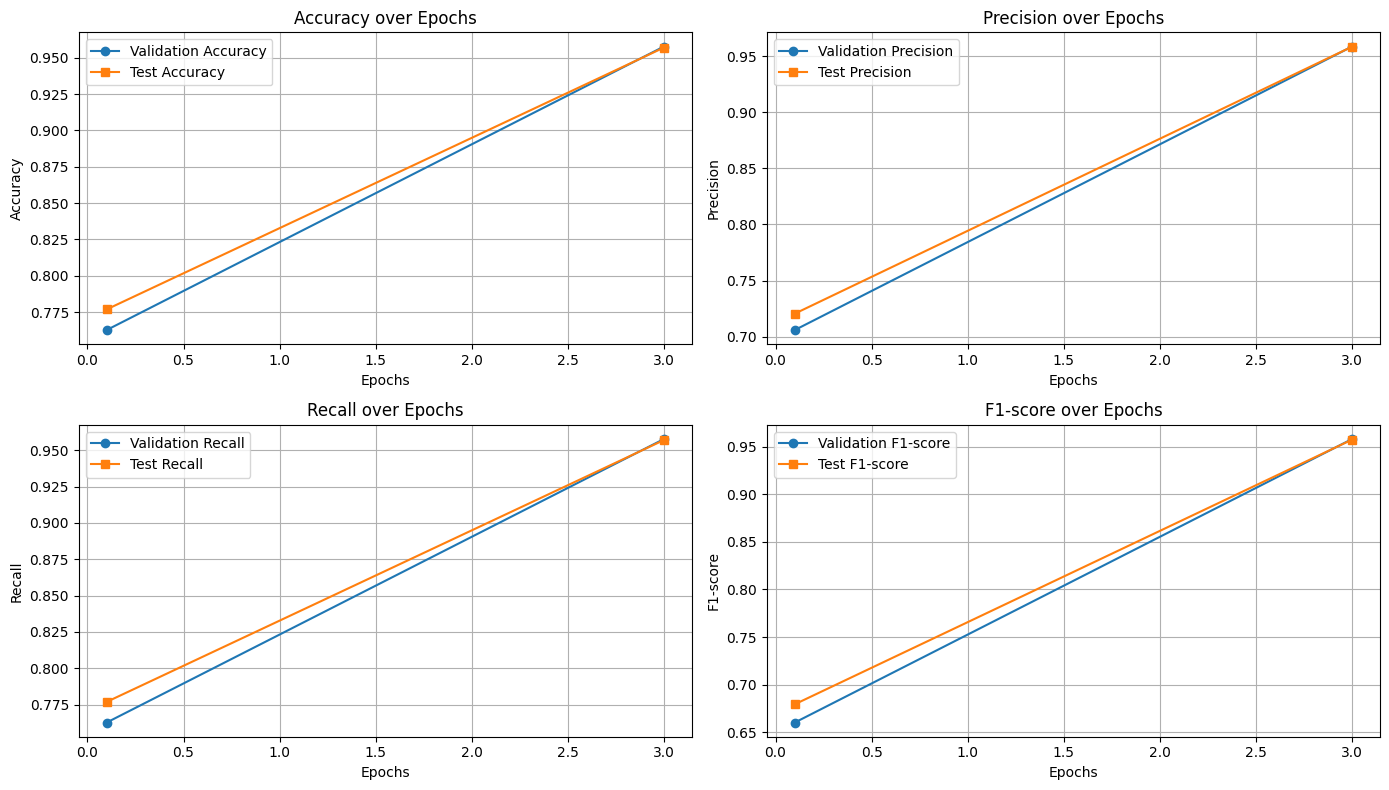

In [33]:
import matplotlib.pyplot as plt

# Epochs
epochs = [0.1,3]

# Validation metrics
val_accuracy = [0.7627,0.9577]
val_precision = [0.7059,0.9585]
val_recall = [0.7627,0.9577]
val_f1score = [0.6602,0.9581]

# Test metrics
test_accuracy = [0.7769,0.9570]
test_precision = [0.7205,0.9584]
test_recall = [0.7769,0.9570]
test_f1score = [0.6794,0.9575]


# Plotting the metrics
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy')
plt.plot(epochs, test_accuracy, 's-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, val_precision, 'o-', label='Validation Precision')
plt.plot(epochs, test_precision, 's-', label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, val_recall, 'o-', label='Validation Recall')
plt.plot(epochs, test_recall, 's-', label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()
plt.grid(True)

# F1-score
plt.subplot(2, 2, 4)
plt.plot(epochs, val_f1score, 'o-', label='Validation F1-score')
plt.plot(epochs, test_f1score, 's-', label='Test F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
